In [1]:
import pandas as pd
import numpy as np
import decoupler as dc
import seaborn as sns
import gseapy as gp
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors
import json
import scipy as sp
from plot_lib import plot_bubbles, plot_enrich
from plotnine import ggsave

In [2]:
#Okabe- Ito palette
pal = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F5C710", "#0072B2", "#D55E00", "#CC79A7", "#999999"]

# define top and bottom colormaps 
top = plt.get_cmap('Oranges_r', 128) # r means reversed version
bottom = plt.get_cmap('Blues', 128)# combine it all
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))# create a new colormaps with a name of OrangeBlue
orange_blue = colors.ListedColormap(newcolors, name='OrangeBlue')

In [3]:
color_pal = {}
for x in zip(["CollecTri", "M2Kb_K-562", "M2Kb_MCF-7", "M2Kb_HepG2", "M2Kb_GM-12878", "CA_K-562", "CA_MCF-7", "CA_HepG2", "CA_GM-12878"], 
             [pal[7], pal[2], pal[3], pal[4], pal[8], pal[1], pal[0], pal[5], pal[6]]):
    color_pal[x[0]] = colors.to_rgba(x[1])
    
cmap = matplotlib.colors.ListedColormap([pal[7], pal[2], pal[3], pal[4], pal[8], pal[1], pal[0], pal[5], pal[6]])
net_dict = {"CollecTri": 7, 
            "M2Kb_K-562": 2, 
            "M2Kb_MCF-7": 3, 
            "M2Kb_HepG2": 4, 
            "M2Kb_GM-12878": 8,
            "CA_K-562": 1,
            "CA_MCF-7": 0,
            "CA_HepG2": 5,
            "CA_GM-12878": 6}

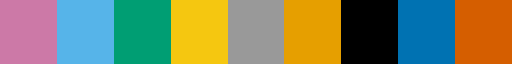

In [4]:
cmap

Network data loading

In [5]:
collectri = dc.get_collectri(organism='human', split_complexes=False)

In [6]:
chip_atlas_k562 = pd.read_table("../data/regulons/ChIP-Atlas_target_genes_K562.tsv", sep="\t")

In [7]:
chip_atlas_k562.head()

,tf,Target_genes
0,ADNP,TRMT2A
1,ADNP,RANBP1
2,ADNP,OSCAR
3,ADNP,NDUFA3
4,ADNP,PSMD9


In [8]:
k562 = pd.read_table("../data/regulons/TF_target_mapping_filtered_merged_K562_with_ppi_with_dnase_with_atac_with_motifs_with_ccres_cleaned.tsv", sep="\t")

k562 = k562.loc[k562.is_M2Kb & (k562.is_pls | k562.is_pels | k562.is_dels), ["tf", "gene_symbol"]].drop_duplicates(["tf", "gene_symbol"])
k562 = k562.loc[k562.tf.isin(collectri.source) & k562.tf.isin(chip_atlas_k562.tf)]
k562.shape

/scratch/47227602/ipykernel_8913/2456411952.py:1: DtypeWarning: Columns (49,51,53,54) have mixed types. Specify dtype option on import or set low_memory=False.


(1021002, 2)

In [9]:
chip_atlas_k562 = chip_atlas_k562.loc[chip_atlas_k562.tf.isin(k562.tf)]
chip_atlas_k562.shape

(1086521, 2)

In [10]:
chip_atlas_gm12878 = pd.read_table("../data/regulons/ChIP-Atlas_target_genes_GM12878.tsv", sep="\t")

In [11]:
gm12878 = pd.read_table("../data/regulons/TF_target_mapping_filtered_merged_GM12878_with_ppi_with_dnase_with_atac_with_motifs_with_ccres.tsv", sep="\t")

gm12878 = gm12878.loc[gm12878.is_M2Kb & (gm12878.is_pls | gm12878.is_pels | gm12878.is_dels), ["tf", "gene_symbol"]].drop_duplicates(["tf", "gene_symbol"])
gm12878 = gm12878.loc[gm12878.tf.isin(collectri.source) & gm12878.tf.isin(chip_atlas_gm12878.tf)]
gm12878.shape

/scratch/47227602/ipykernel_8913/582809249.py:1: DtypeWarning: Columns (8,24,53,55,57,58) have mixed types. Specify dtype option on import or set low_memory=False.


(423210, 2)

In [12]:
chip_atlas_gm12878 = chip_atlas_gm12878.loc[chip_atlas_gm12878.tf.isin(gm12878.tf)]
chip_atlas_gm12878.shape

(1576755, 2)

In [13]:
collectri = collectri[collectri.source.isin(k562.tf) | collectri.source.isin(gm12878.tf)]

### Prepare cosmic

In [14]:
COSMIC = dc.get_resource('CancerGeneCensus')

COSMIC.tumour_types_somatic = COSMIC.tumour_types_somatic.str.split(";")

COSMIC = COSMIC.explode("tumour_types_somatic")
cosmic_dict = {}
for typ in COSMIC.tumour_types_somatic.drop_duplicates():
    if COSMIC.loc[COSMIC.tumour_types_somatic == typ].genesymbol.shape[0] > 1:
        cosmic_dict[typ] = COSMIC.loc[COSMIC.tumour_types_somatic == typ].genesymbol.to_list()

### C6 cells leukemic vs healthy

In [15]:
data = pd.read_csv("../data/case_study/c6_leukemic_vs_healthy_aml_dataset.csv", sep=";", index_col=0)
#data = pd.read_csv("data/aml_case_study/c6_vs_other_cells_aml_dataset.csv", sep=";", index_col=0)
#data = pd.read_csv("data/aml_case_study/c6_vs_other_leukemic_cells_aml_dataset.csv", sep=";", index_col=0)
data

,n patients up,n patients down,Mean log2 Fold Change,SD log2 FC,Sum of log p values,n patients significant (consistent sign),Metadata: Rodriguez-Fraticelli,Metadata: Zhang
Gene,,,,,,,,
BST2,5,0,"1,7700744366",1,25,5,Other,dHSC
CFD,0,5,"-1,5632001468",1,17,5,Other,Other
IFITM3,5,0,"1,3214619090",1,22,5,dHSC,Other
ALDH1A1,4,0,"1,1047309844",1,20,4,dHSC,Other
AVP,4,0,"2,8423696458",1,29,4,Other,dHSC
...,...,...,...,...,...,...,...,...
VSIR,1,1,"0,0047056800",0,5,0,Other,Other
YWHAE,1,1,"0,0690342600",0,6,0,Other,Other
ZFAND1,1,1,"-0,1537241000",1,7,0,Other,Other


In [16]:
#data = data[data["Metadata: Velten"] == "Erythromyeloid priming"]
de_genes = data.loc[data["n patients significant (consistent sign)"] > 0]["Mean log2 Fold Change"].str.replace(",",'.').astype("float").to_frame()
de_genes.head()
de_genes["leukemic"] = - de_genes["Mean log2 Fold Change"]
de_genes

,Mean log2 Fold Change,leukemic
Gene,,
BST2,1.770074,-1.770074
CFD,-1.563200,1.563200
IFITM3,1.321462,-1.321462
ALDH1A1,1.104731,-1.104731
AVP,2.842370,-2.842370
...,...,...
ZNF700,-0.293188,0.293188
ZNF71,-0.539847,0.539847
ZNF711,0.432657,-0.432657


In [17]:
enr = gp.enrich(de_genes.loc[de_genes["leukemic"].abs() > 1, :].index.to_list(), "DisGeNET")

enr.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,DisGeNET,leukemia,64/1941,9.533245e-19,3.989663e-15,0,0,4.561105,189.260002,KDM5B;CXCL8;CSF1;PLEK;HPGDS;LGALS1;MYC;CASP3;S...
1,DisGeNET,"Leukemia, Myelocytic, Acute",55/1703,1.426761e-15,2.720491e-12,0,0,4.236837,144.829371,CXCL8;CSF1;MSLN;HPGDS;MYC;CASP3;STMN1;PIM1;CD3...
2,DisGeNET,Rheumatoid Arthritis,57/1833,1.950173e-15,2.720491e-12,0,0,4.103100,138.975534,BTG2;CD84;CXCL8;CSF1;NCF4;PLEK;BHLHE41;ICAM3;C...
3,DisGeNET,Acute lymphocytic leukemia,39/907,6.091788e-15,6.373533e-12,0,0,5.350448,175.129973,CXCL8;CSF1;GSTP1;MLLT3;MSLN;GATA1;P2RY8;SOCS3;...
4,DisGeNET,"Lupus Erythematosus, Systemic",43/1113,8.424787e-15,7.051547e-12,0,0,4.856654,157.392478,FOXC1;CD84;CXCL8;CSF1;GSTP1;ICAM3;CLU;SOCS2;SO...
...,...,...,...,...,...,...,...,...,...,...
4180,DisGeNET,Mitochondrial Diseases,2/384,8.962123e-01,8.970697e-01,0,0,0.518752,0.056844,CASP3;SOD2
4181,DisGeNET,Visual Impairment,1/251,9.189818e-01,9.196411e-01,0,0,0.396995,0.033542,ARID1B
4182,DisGeNET,Cerebellar Ataxia,3/565,9.212140e-01,9.216545e-01,0,0,0.526690,0.043222,TUBB;CASP3;NBN
4183,DisGeNET,Low Vision,1/261,9.267492e-01,9.269707e-01,0,0,0.381531,0.029024,ARID1B


In [18]:
de_genes.drop("Mean log2 Fold Change", axis=1, inplace=True)

In [19]:
de_genes = de_genes.T

In [20]:
dc.check_corr(k562, mat=de_genes, source="tf", target="gene_symbol", weight=None).sort_values("corr")

,source1,source2,corr
9313,GTF2B,RBFOX2,-0.1727
13289,RBFOX2,SIRT6,-0.1274
13586,CEBPD,RBFOX2,-0.1243
14029,NONO,RBFOX2,-0.1201
14106,E2F1,GATAD2B,-0.1193
...,...,...,...
4,CREM,MAX,0.6051
3,CREM,NEUROD1,0.6063
2,MAX,MAZ,0.6066
1,JUND,NEUROD1,0.6139


In [21]:
dc.check_corr(collectri, mat=de_genes, weight=None).sort_values("corr")

,source1,source2,corr
3601,E2F4,SP1,-0.0742
3840,SREBF1,TP53,-0.0676
4083,KLF1,SP1,-0.0598
4184,MYC,SREBF2,-0.0566
4213,E2F6,SP1,-0.0554
...,...,...,...
4,SMAD1,SMAD5,0.5298
3,FOS,JUN,0.5309
2,USF1,USF2,0.5554
1,CTNNB1,TCF7L2,0.5926


In [22]:
aml_disreg_enrich = pd.DataFrame()
aml_omim_enrich = pd.DataFrame()
aml_cosmic_enrich = pd.DataFrame()
megaheat = pd.DataFrame()

K562

In [23]:
tf_acts_k562, tf_pvals_k562= dc.run_ulm(de_genes, k562, source='tf', target='gene_symbol', weight=None)

#tf_pvals.loc["leukemic"] = fdrcorrection(tf_pvals.T["leukemic"])[1]

In [24]:
mask = tf_pvals_k562< 0.05

active_tfs_k562 = tf_acts_k562.loc["leukemic", pd.DataFrame(tf_acts_k562 * mask).sum(axis=0) != 0].index.to_list()

In [25]:
tf_acts_k562.index = ["score"]
tf_pvals_k562.index = ["p_value"]
out_k562 = pd.merge(left=tf_acts_k562.T, right=tf_pvals_k562.T, left_index=True, right_index=True)
out_k562.to_csv("../data/3-tf_activity/aml_dhsc_ahsc_activity_m2kb_k562.tsv", sep="\t", index=False)

In [26]:
enr = gp.enrich(active_tfs_k562, "OMIM_Expanded")
enr.results["Network"] = "M2Kb_K-562"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_omim_enrich_m2kb_k562_dhsc_ahsc.tsv", sep="\t", index=False)
aml_omim_enrich = pd.concat([aml_omim_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [27]:
enr = gp.enrich(active_tfs_k562, "DisGeNET")
enr.results["Network"] = "M2Kb_K-562"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_disgenet_enrich_m2kb_k562_dhsc_ahsc.tsv", sep="\t", index=False)
aml_disreg_enrich = pd.concat([aml_disreg_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [28]:
try:
    enr = gp.enrich(gene_list=active_tfs_k562, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "M2Kb_K-562"
    enr.results.to_csv("../data/3-tf_disease_enrichment/aml_cosmic_enrich_m2kb_k562_dhsc_ahsc.tsv", sep="\t", index=False)
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "M2Kb_K-562"
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, pd.DataFrame()], axis=0)

In [29]:
heat = pd.concat([tf_acts_k562.rename({"leukemic": "score"}), tf_pvals_k562.rename({"leukemic": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("leukemic", ascending=False).index).head(5)
heat["Network"] = "M2Kb_K-562"
#heat["TFs"] = heat.index
megaheat = pd.concat([megaheat, heat], axis =0)
megaheat

,score,p_value,Network
ADNP,1.078251,0.281042,M2Kb_K-562
ARHGAP35,-0.232683,0.816030,M2Kb_K-562
ARID1B,0.423085,0.672276,M2Kb_K-562
ARID3A,0.597754,0.550067,M2Kb_K-562
ARID3B,0.638854,0.522986,M2Kb_K-562
...,...,...,...
ZNF436,1.896163,0.058072,M2Kb_K-562
ZNF444,1.736354,0.082644,M2Kb_K-562
ZNF76,2.023865,0.043107,M2Kb_K-562
ZNF77,0.387900,0.698128,M2Kb_K-562


CollecTri

In [30]:
tf_acts_ctri, tf_pvals_ctri = dc.run_ulm(de_genes, collectri)
#tf_pvals_ctri.loc["leukemic"] = fdrcorrection(tf_pvals_ctri.T["leukemic"])[1]

In [31]:
mask_ctri = tf_pvals_ctri < 0.05
active_tfs_ctri = tf_acts_ctri.loc["leukemic", pd.DataFrame(tf_acts_ctri * mask_ctri).sum(axis=0) != 0].index.to_list()
tf_acts_ctri.loc["leukemic", pd.DataFrame(tf_acts_ctri * mask_ctri).sum(axis=0) != 0]

ATF3      -2.941248
BHLHE40    2.246815
CEBPG     -2.562517
CREB1     -3.624266
DLX4      -1.979575
EP300     -1.961076
ERG        1.981860
HSF1      -2.136341
IKZF1     -2.091377
IRF1      -4.248643
KLF1       2.616677
LEF1       2.502891
MAFK      -2.458096
MBD2       2.575544
MEF2A     -2.943967
MITF       4.227231
MYC       -2.338482
NFE2       4.751493
NFYB      -2.532985
NR2C2     -2.769127
RELA      -2.857900
RFX1      -5.004245
RFX5      -8.666896
SP1       -2.313753
TBX21     -2.406118
THRA      -3.440546
USF2      -2.084898
YBX1      -2.735002
YY1       -3.571998
ZEB1       1.985951
Name: leukemic, dtype: float32

In [32]:
tf_acts_ctri.index = ["score"]
tf_pvals_ctri.index = ["p_value"]
out_ctri = pd.merge(left=tf_acts_ctri.T, right=tf_pvals_ctri.T, left_index=True, right_index=True)
out_ctri.to_csv("../data/3-tf_activity/aml_dhsc_ahsc_activity_collectri.tsv", sep="\t", index=False)

In [33]:
enr = gp.enrich(active_tfs_ctri, "OMIM_Expanded")
enr.results["Network"] = "CollecTri"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_omim_enrich_collectri_dhsc_ahsc.tsv", sep="\t", index=False)
aml_omim_enrich = pd.concat([aml_omim_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [34]:
enr = gp.enrich(active_tfs_ctri, "DisGeNET")
enr.results["Network"] = "CollecTri"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_disgenet_enrich_collectri_dhsc_ahsc.tsv", sep="\t", index=False)
aml_disreg_enrich = pd.concat([aml_disreg_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [35]:
try:
    enr = gp.enrich(gene_list=active_tfs_ctri, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "CollecTri"
    enr.results.to_csv("../data/3-tf_disease_enrichment/aml_cosmic_enrich_collectri_dhsc_ahsc.tsv", sep="\t", index=False)
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "CollecTri"
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, pd.DataFrame()], axis=0)

In [36]:
heat = pd.concat([tf_acts_ctri.rename({"leukemic": "score"}), tf_pvals_ctri.rename({"leukemic": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("leukemic", ascending=False).index).head(5)
heat["Network"] = "CollecTri"
#heat["TFs"] = heat.index
megaheat = pd.concat([megaheat, heat], axis =0)
megaheat

,score,p_value,Network
ADNP,1.078251,0.281042,M2Kb_K-562
ARHGAP35,-0.232683,0.816030,M2Kb_K-562
ARID1B,0.423085,0.672276,M2Kb_K-562
ARID3A,0.597754,0.550067,M2Kb_K-562
ARID3B,0.638854,0.522986,M2Kb_K-562
...,...,...,...
YY1,-3.571998,0.000362,CollecTri
ZBED1,0.267935,0.788775,CollecTri
ZBTB7A,-0.141364,0.887595,CollecTri
ZEB1,1.985951,0.047165,CollecTri


chip_atlas_k562

In [37]:
tf_acts_chip_atlas_k562, tf_pvals_chip_atlas_k562= dc.run_ulm(de_genes, chip_atlas_k562.drop_duplicates(), source='tf', target='Target_genes', weight=None)

#tf_pvals.loc["leukemic"] = fdrcorrection(tf_pvals.T["leukemic"])[1]

In [38]:
mask = tf_pvals_chip_atlas_k562 < 0.05

active_tfs_chip_atlas_k562 = tf_acts_chip_atlas_k562.loc["leukemic", pd.DataFrame(tf_acts_chip_atlas_k562 * mask).sum(axis=0) != 0].index.to_list()

In [39]:
active_tfs_chip_atlas_k562

['ARID1B',
 'ATF1',
 'ATF3',
 'ATF7',
 'BCOR',
 'BHLHE40',
 'BRD4',
 'CEBPD',
 'CEBPZ',
 'CREB1',
 'CREB3L1',
 'CREM',
 'CTBP1',
 'CTCF',
 'CTCFL',
 'CUX1',
 'E2F4',
 'E2F5',
 'E2F6',
 'E4F1',
 'EGR1',
 'ELF1',
 'ELF4',
 'ELK1',
 'EP300',
 'ERG',
 'ESRRA',
 'ETS1',
 'ETV1',
 'FOSL1',
 'GABPA',
 'GATA1',
 'GATAD2B',
 'GFI1B',
 'GMEB1',
 'GTF2B',
 'GTF2F1',
 'HCFC1',
 'HDAC1',
 'HEY1',
 'ID3',
 'IRF1',
 'JUN',
 'JUND',
 'KDM5B',
 'MAX',
 'MAZ',
 'MBD2',
 'MEF2A',
 'MEF2D',
 'MGA',
 'MITF',
 'MNT',
 'MTA3',
 'MXI1',
 'MYC',
 'NCOR1',
 'NEUROD1',
 'NFIC',
 'NFIX',
 'NFYA',
 'NFYB',
 'NONO',
 'NR2C2',
 'NR4A1',
 'NRF1',
 'PHF20',
 'PHF8',
 'PLAG1',
 'PML',
 'PRDM10',
 'RB1',
 'RBFOX2',
 'RCOR1',
 'REST',
 'RFX5',
 'SAP30',
 'SIN3A',
 'SIN3B',
 'SIX5',
 'SKIL',
 'SMAD5',
 'SMARCA4',
 'SOX6',
 'SP1',
 'SP2',
 'SPI1',
 'SREBF1',
 'SRF',
 'TAF1',
 'TBP',
 'TEAD1',
 'TFDP1',
 'THAP1',
 'TRIM28',
 'UBTF',
 'USF1',
 'USF2',
 'VEZF1',
 'YY1',
 'ZBTB7A',
 'ZFX',
 'ZNF148',
 'ZNF24',
 'ZNF281',
 'ZNF

In [40]:
tf_acts_chip_atlas_k562.index = ["score"]
tf_pvals_chip_atlas_k562.index = ["p_value"]
out_chip_atlas_k562 = pd.merge(left=tf_acts_chip_atlas_k562.T, right=tf_pvals_chip_atlas_k562.T, left_index=True, right_index=True)
out_chip_atlas_k562.to_csv("../data/3-tf_activity/aml_dhsc_ahsc_activity_ca_k562.tsv", sep="\t", index=False)

In [41]:
enr = gp.enrich(active_tfs_chip_atlas_k562, "OMIM_Expanded")
enr.results["Network"] = "CA_K-562"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_omim_enrich_ca_k562_dhsc_ahsc.tsv", sep="\t", index=False)
aml_omim_enrich = pd.concat([aml_omim_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [42]:
enr = gp.enrich(active_tfs_chip_atlas_k562, "DisGeNET")
enr.results["Network"] = "CA_K-562"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_disgenet_enrich_ca_k562_dhsc_ahsc.tsv", sep="\t", index=False)
aml_disreg_enrich = pd.concat([aml_disreg_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [43]:
try:
    enr = gp.enrich(gene_list=active_tfs_chip_atlas_k562, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "CA_K-562"
    enr.results.to_csv("../data/3-tf_disease_enrichment/aml_cosmic_enrich_ca_k562_dhsc_ahsc.tsv", sep="\t", index=False)
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "CA_K-562"
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, pd.DataFrame()], axis=0)

In [44]:
heat = pd.concat([tf_acts_chip_atlas_k562.rename({"leukemic": "score"}), tf_pvals_chip_atlas_k562.rename({"leukemic": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("leukemic", ascending=False).index).head(5)
heat["Network"] = "CA_K-562"
#heat["TFs"] = heat.index
megaheat = pd.concat([megaheat, heat], axis =0)
megaheat

,score,p_value,Network
ADNP,1.078251,0.281042,M2Kb_K-562
ARHGAP35,-0.232683,0.816030,M2Kb_K-562
ARID1B,0.423085,0.672276,M2Kb_K-562
ARID3A,0.597754,0.550067,M2Kb_K-562
ARID3B,0.638854,0.522986,M2Kb_K-562
...,...,...,...
ZNF436,0.343921,0.730939,CA_K-562
ZNF444,0.488123,0.625513,CA_K-562
ZNF76,0.664738,0.506289,CA_K-562
ZNF77,-0.207646,0.835525,CA_K-562


chip_atlas_12878

In [45]:
aml_disreg_enrich

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Network
0,DisGeNET,Carcinogenesis,90/4065,4.908466e-33,1.467631e-29,0,0,8.777174,652.972155,RB1;ATF1;KDM5B;PHF20;CTCF;ELK1;ETS1;PHF8;YY1;S...,M2Kb_K-562
1,DisGeNET,Tumor Progression,62/2090,7.289546e-27,1.089787e-23,0,0,7.904854,475.740631,RB1;KDM5B;SPI1;CTCF;ELK1;ETS1;YY1;SIN3B;CREB3L...,M2Kb_K-562
2,DisGeNET,Breast Carcinoma,88/4963,1.521667e-24,1.516595e-21,0,0,6.294440,345.201168,RB1;KDM5B;CTCF;ELK1;ETS1;YY1;SIN3B;ZMIZ1;SIN3A...,M2Kb_K-562
3,DisGeNET,Malignant neoplasm of prostate,72/3239,2.595042e-24,1.939794e-21,0,0,6.435776,349.516937,RB1;KDM5B;CTCF;ELK1;ETS1;PHF8;YY1;SIN3B;ZMIZ1;...,M2Kb_K-562
4,DisGeNET,Prostate carcinoma,70/3145,1.771921e-23,1.059609e-20,0,0,6.267253,328.325049,RB1;KDM5B;CTCF;ELK1;ETS1;PHF8;YY1;SIN3B;ZMIZ1;...,M2Kb_K-562
0,DisGeNET,"Leukemia, Myelocytic, Acute",17/1703,2.462260e-11,3.838664e-08,0,0,14.181403,346.414194,DLX4;THRA;NFYB;MBD2;LEF1;CEBPG;IKZF1;NR2C2;REL...,CollecTri
1,DisGeNET,Tumor Progression,18/2090,5.180162e-11,4.037936e-08,0,0,12.957046,306.869498,DLX4;MBD2;MITF;RFX1;YBX1;NR2C2;USF2;RELA;YY1;Z...,CollecTri
2,DisGeNET,MYELODYSPLASTIC SYNDROME,12/683,1.124683e-10,5.844603e-08,0,0,19.174367,439.253094,YY1;CREB1;DLX4;IRF1;MYC;MBD2;LEF1;EP300;MAFK;E...,CollecTri
3,DisGeNET,Mammary Neoplasms,18/2387,4.735382e-10,1.845615e-07,0,0,11.144576,239.282829,MEF2A;DLX4;THRA;MBD2;LEF1;YBX1;NR2C2;USF2;RELA...,CollecTri
4,DisGeNET,Carcinogenesis,22/4065,5.997901e-10,1.870145e-07,0,0,10.833354,230.040220,MEF2A;THRA;MBD2;LEF1;MITF;RFX1;YBX1;IKZF1;NR2C...,CollecTri


Plotting results

In [67]:
okabe = [pal[1], pal[7], pal[2]]

In [68]:
aml_omim_enrich["-log10(Adj. P-value)"] = - np.log10(aml_omim_enrich["Adjusted P-value"])
aml_omim_enrich = aml_omim_enrich.loc[aml_omim_enrich["Adjusted P-value"] < 0.05]
aml_omim_enrich.describe()

,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,1.500000e+01,1.500000e+01,15.0,15.0,15.000000,15.000000,15.000000
mean,1.696395e-06,5.252545e-05,0.0,0.0,27.312652,420.711435,5.272817
std,2.636460e-06,7.249181e-05,0.0,0.0,16.191327,262.851547,1.264895
min,5.825182e-10,1.077659e-07,0.0,0.0,14.860500,177.703353,3.802433
25%,8.609804e-08,1.695725e-07,0.0,0.0,15.769731,208.296635,3.854438
50%,1.710990e-07,6.528335e-06,0.0,0.0,16.717981,271.964427,5.185198
75%,2.942151e-06,1.408212e-04,0.0,0.0,48.507317,752.973144,6.770644
max,6.407121e-06,1.576039e-04,0.0,0.0,51.005128,803.829984,6.967519


/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/aml_go_enrich_omim_dhsc_ahsc_new.svg


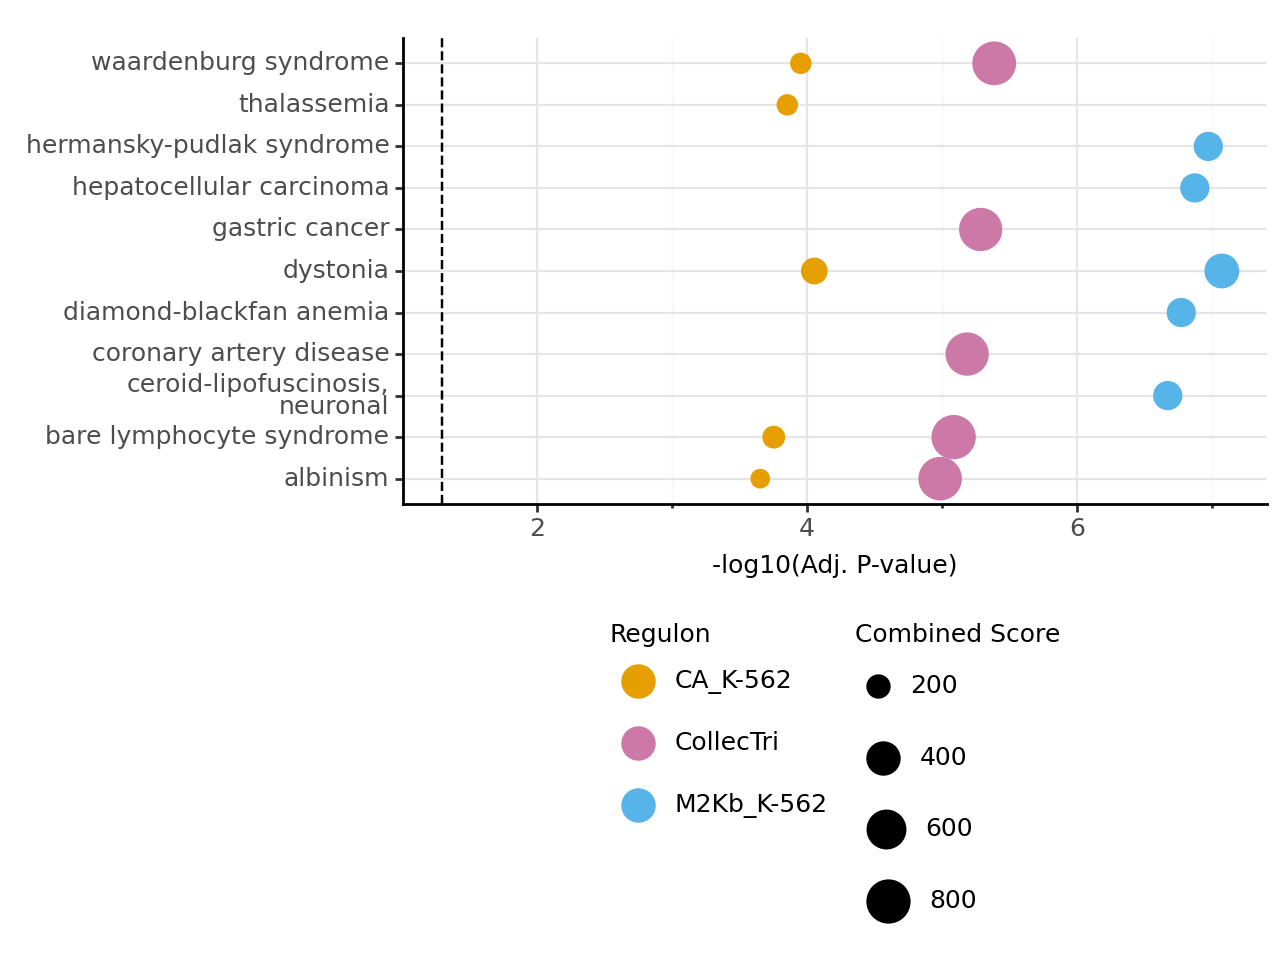

<Figure Size: (640 x 480)>

In [69]:
p = plot_enrich(aml_omim_enrich, okabe)
ggsave(p, "../plots/3-tf_disease_enrichment/aml_go_enrich_omim_dhsc_ahsc_new.svg",  width = 30, height = 150, units = "mm", dpi=720)
p

In [70]:
aml_disreg_enrich["-log10(Adj. P-value)"] = - np.log10(aml_disreg_enrich["Adjusted P-value"])
aml_disreg_enrich = aml_disreg_enrich.loc[aml_disreg_enrich["Adjusted P-value"] < 0.05]
aml_disreg_enrich.describe()

,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,1.500000e+01,1.500000e+01,15.0,15.0,15.000000,15.000000,15.000000
mean,8.414806e-11,3.391921e-08,0.0,0.0,9.309367,364.214314,15.792390
std,1.877901e-10,6.453110e-08,0.0,0.0,3.792266,127.960616,7.306765
min,4.908466e-33,1.467631e-29,0.0,0.0,5.659732,217.149981,6.728125
25%,2.058354e-24,1.728194e-21,0.0,0.0,6.365108,269.887538,7.404830
50%,5.807200e-20,5.042585e-17,0.0,0.0,8.119889,345.201168,16.297347
75%,3.821211e-11,3.938300e-08,0.0,0.0,10.988965,425.510586,20.765687
max,5.997901e-10,1.870145e-07,0.0,0.0,19.174367,652.972155,28.833383


/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/aml_go_enrich_disreg_dhsc_ahsc_new.svg


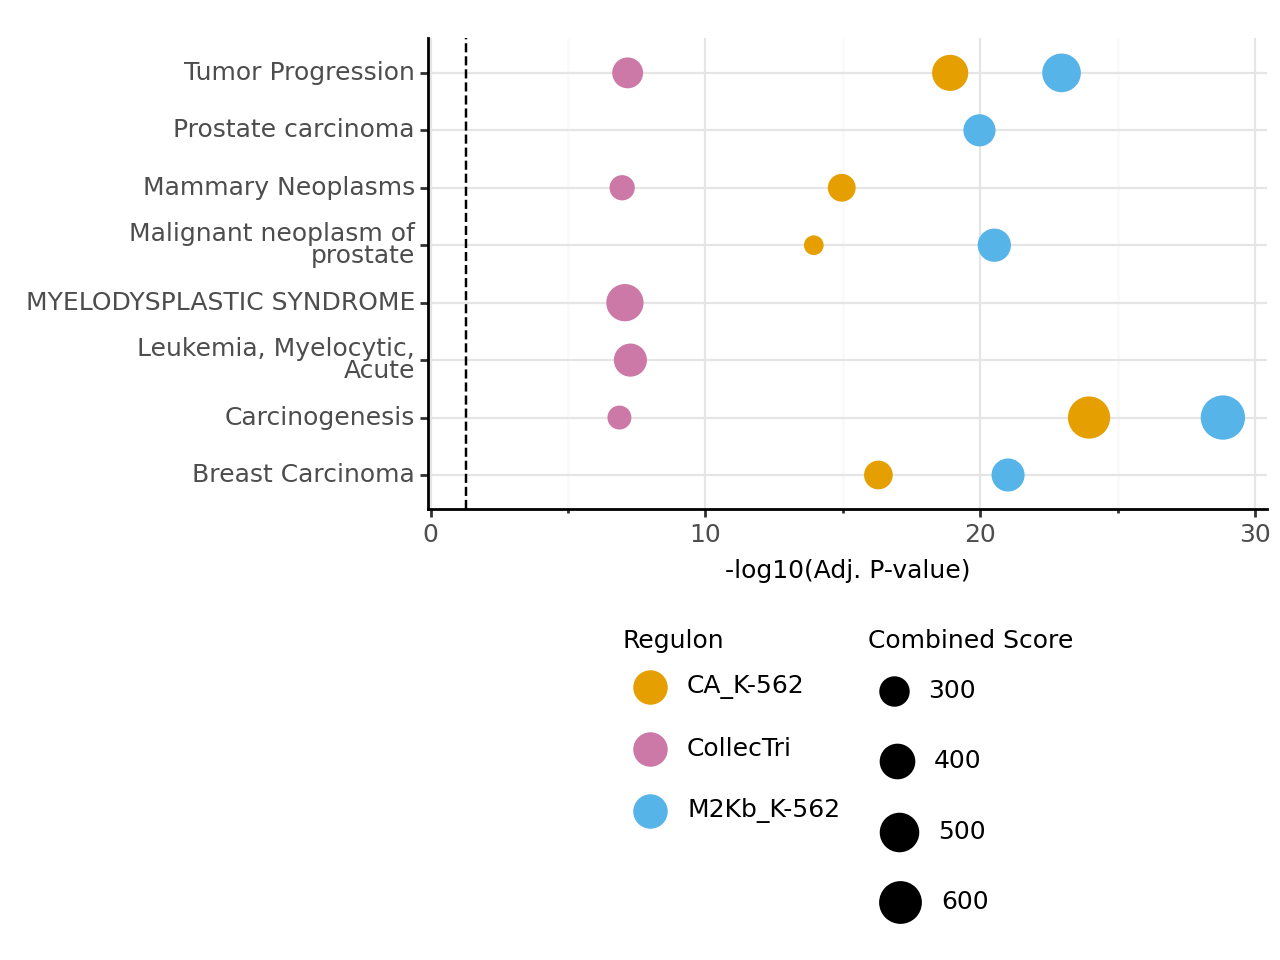

<Figure Size: (640 x 480)>

In [71]:
p = plot_enrich(aml_disreg_enrich, okabe)
ggsave(p, "../plots/3-tf_disease_enrichment/aml_go_enrich_disreg_dhsc_ahsc_new.svg",  width = 30, height = 150, units = "mm", dpi=720)
p

In [72]:
aml_cosmic_enrich["-log10(Adj. P-value)"] = - np.log10(aml_cosmic_enrich["Adjusted P-value"])
aml_cosmic_enrich = aml_cosmic_enrich.loc[aml_cosmic_enrich["Adjusted P-value"] < 0.05]
aml_cosmic_enrich.describe()

,P-value,Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,9.000000,9.000000,9.000000,9.000000,9.000000
mean,0.001748,0.014806,23.210529,167.570177,2.037659
std,0.001502,0.009218,7.029016,71.154092,0.596785
min,0.000023,0.000828,7.805831,54.968830,1.593212
25%,0.000874,0.012458,21.157598,124.658750,1.680712
50%,0.001384,0.017377,21.933798,184.460403,1.760013
75%,0.003402,0.020859,28.022222,207.930607,1.904565
max,0.004056,0.025515,30.756098,290.955620,3.082182


/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/aml_go_enrich_cosmic_dhsc_ahsc_new.svg


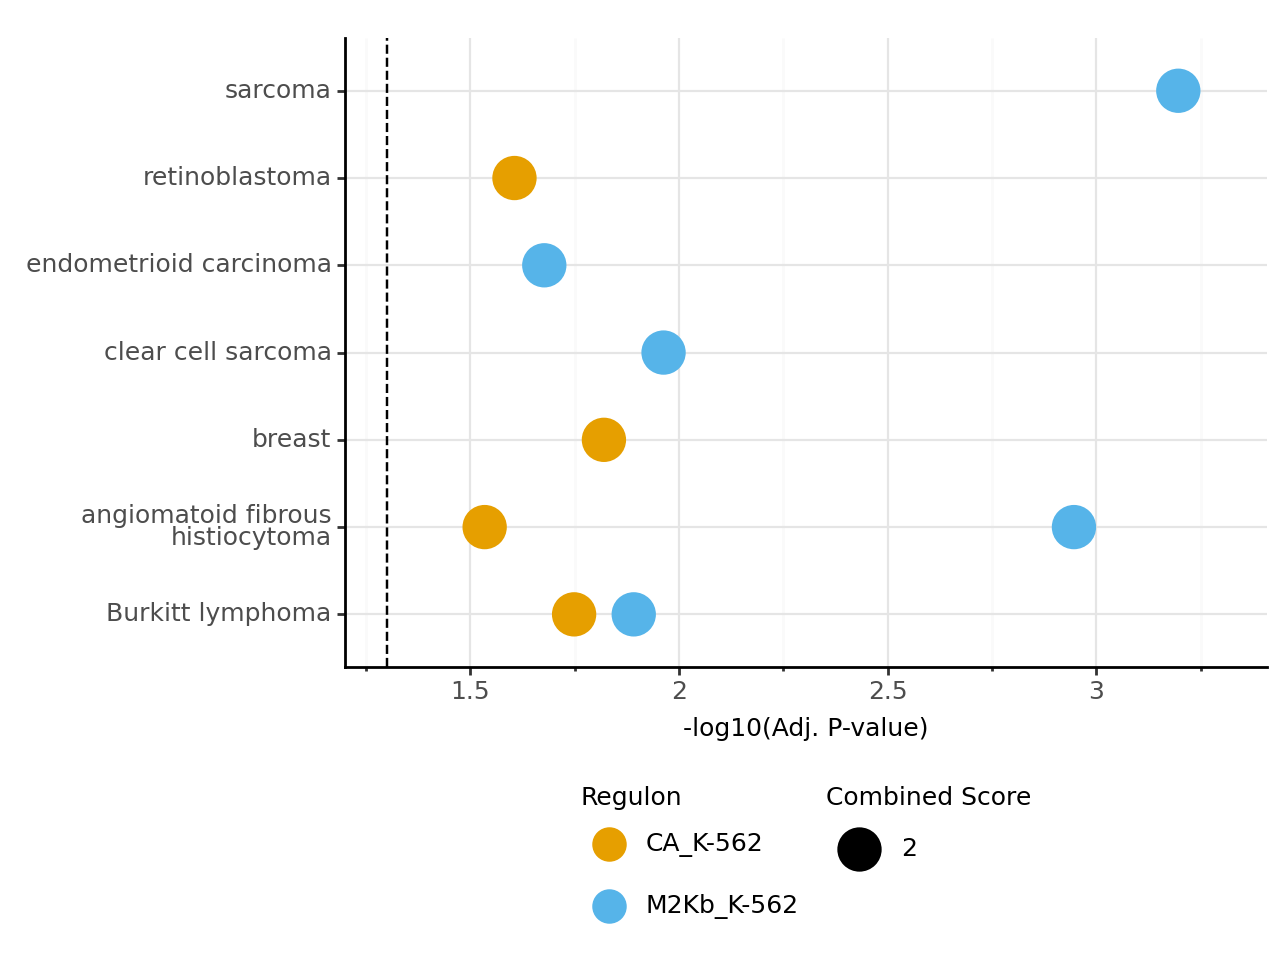

<Figure Size: (640 x 480)>

In [77]:
p = plot_enrich(aml_cosmic_enrich, [ pal[1], pal[2]], size=2)
ggsave(p, "../plots/3-tf_disease_enrichment/aml_go_enrich_cosmic_dhsc_ahsc_new.svg", width = 30, height = 150, units = "mm", dpi=720)
p

In [78]:
megaheat.describe()

,score,p_value,log_p
count,267.000000,2.670000e+02,267.000000
mean,3.181342,7.837537e-03,4.109363
std,2.407112,1.240641e-02,2.606619
min,-8.666896,8.561306e-18,1.300000
25%,2.379979,1.565474e-06,1.950000
50%,3.360909,5.114760e-04,3.300000
75%,4.787547,1.126334e-02,5.800000
max,6.741618,4.999873e-02,17.100000


In [79]:
megaheat.to_csv("../data/3-tf_activity/aml_activity_estimates_dhsc_ahsc.tsv", sep="\t", index=False)

In [80]:
megaheat = megaheat[megaheat.p_value < 0.05].sort_values("score")
megaheat["TF"] = megaheat.index
megaheat["log_p"] = - np.log10(megaheat.p_value).round(1)
#megaheat["log_p"] = megaheat["log_p"].astype("str")

In [81]:
print(megaheat[megaheat.Network == "M2Kb_K-562"].sort_values("score").to_string())

            score       p_value     Network       TF  log_p
NFIX    -2.331227  1.983314e-02  M2Kb_K-562     NFIX    1.7
MAFK     1.987557  4.698700e-02  M2Kb_K-562     MAFK    1.3
ZNF76    2.023865  4.310711e-02  M2Kb_K-562    ZNF76    1.4
CBFA2T3  2.041083  4.136411e-02  M2Kb_K-562  CBFA2T3    1.4
SP2      2.059811  3.953637e-02  M2Kb_K-562      SP2    1.4
ZEB2     2.063842  3.915215e-02  M2Kb_K-562     ZEB2    1.4
RUNX1    2.085236  3.716524e-02  M2Kb_K-562    RUNX1    1.4
FOXK2    2.094775  3.630744e-02  M2Kb_K-562    FOXK2    1.4
MTA2     2.097207  3.609147e-02  M2Kb_K-562     MTA2    1.4
ZBTB2    2.099511  3.588782e-02  M2Kb_K-562    ZBTB2    1.4
SMARCE1  2.150585  3.161982e-02  M2Kb_K-562  SMARCE1    1.5
ZBTB12   2.155712  3.121647e-02  M2Kb_K-562   ZBTB12    1.5
ZNF24    2.167140  3.033335e-02  M2Kb_K-562    ZNF24    1.5
E2F1     2.190149  2.862019e-02  M2Kb_K-562     E2F1    1.5
GATA1    2.204308  2.760797e-02  M2Kb_K-562    GATA1    1.6
ESRRB    2.231091  2.577757e-02  M2Kb_K-

In [82]:
print(megaheat[megaheat.Network == "CollecTri"].sort_values("score").to_string())

            score       p_value    Network       TF  log_p
RFX5    -8.666896  8.561306e-18  CollecTri     RFX5   17.1
RFX1    -5.004245  6.062165e-07  CollecTri     RFX1    6.2
IRF1    -4.248643  2.242190e-05  CollecTri     IRF1    4.6
CREB1   -3.624266  2.964938e-04  CollecTri    CREB1    3.5
YY1     -3.571998  3.620332e-04  CollecTri      YY1    3.4
THRA    -3.440546  5.915945e-04  CollecTri     THRA    3.2
MEF2A   -2.943967  3.274992e-03  CollecTri    MEF2A    2.5
ATF3    -2.941248  3.303761e-03  CollecTri     ATF3    2.5
RELA    -2.857900  4.305477e-03  CollecTri     RELA    2.4
NR2C2   -2.769127  5.668788e-03  CollecTri    NR2C2    2.2
YBX1    -2.735002  6.289051e-03  CollecTri     YBX1    2.2
CEBPG   -2.562517  1.045901e-02  CollecTri    CEBPG    2.0
NFYB    -2.532985  1.137994e-02  CollecTri     NFYB    1.9
MAFK    -2.458096  1.404574e-02  CollecTri     MAFK    1.9
TBX21   -2.406118  1.620674e-02  CollecTri    TBX21    1.8
MYC     -2.338482  1.945321e-02  CollecTri      MYC    1

In [83]:
print(megaheat[megaheat.Network == "M2Kb_GM-12878"].sort_values("score").to_string())

Empty DataFrame
Columns: [score, p_value, Network, TF, log_p]
Index: []


/crex/proj/lappalainen_lab1/users/marii/chip_seq_ann/case_studies/plot_lib.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/crex/proj/lappalainen_lab1/users/marii/chip_seq_ann/case_studies/plot_lib.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


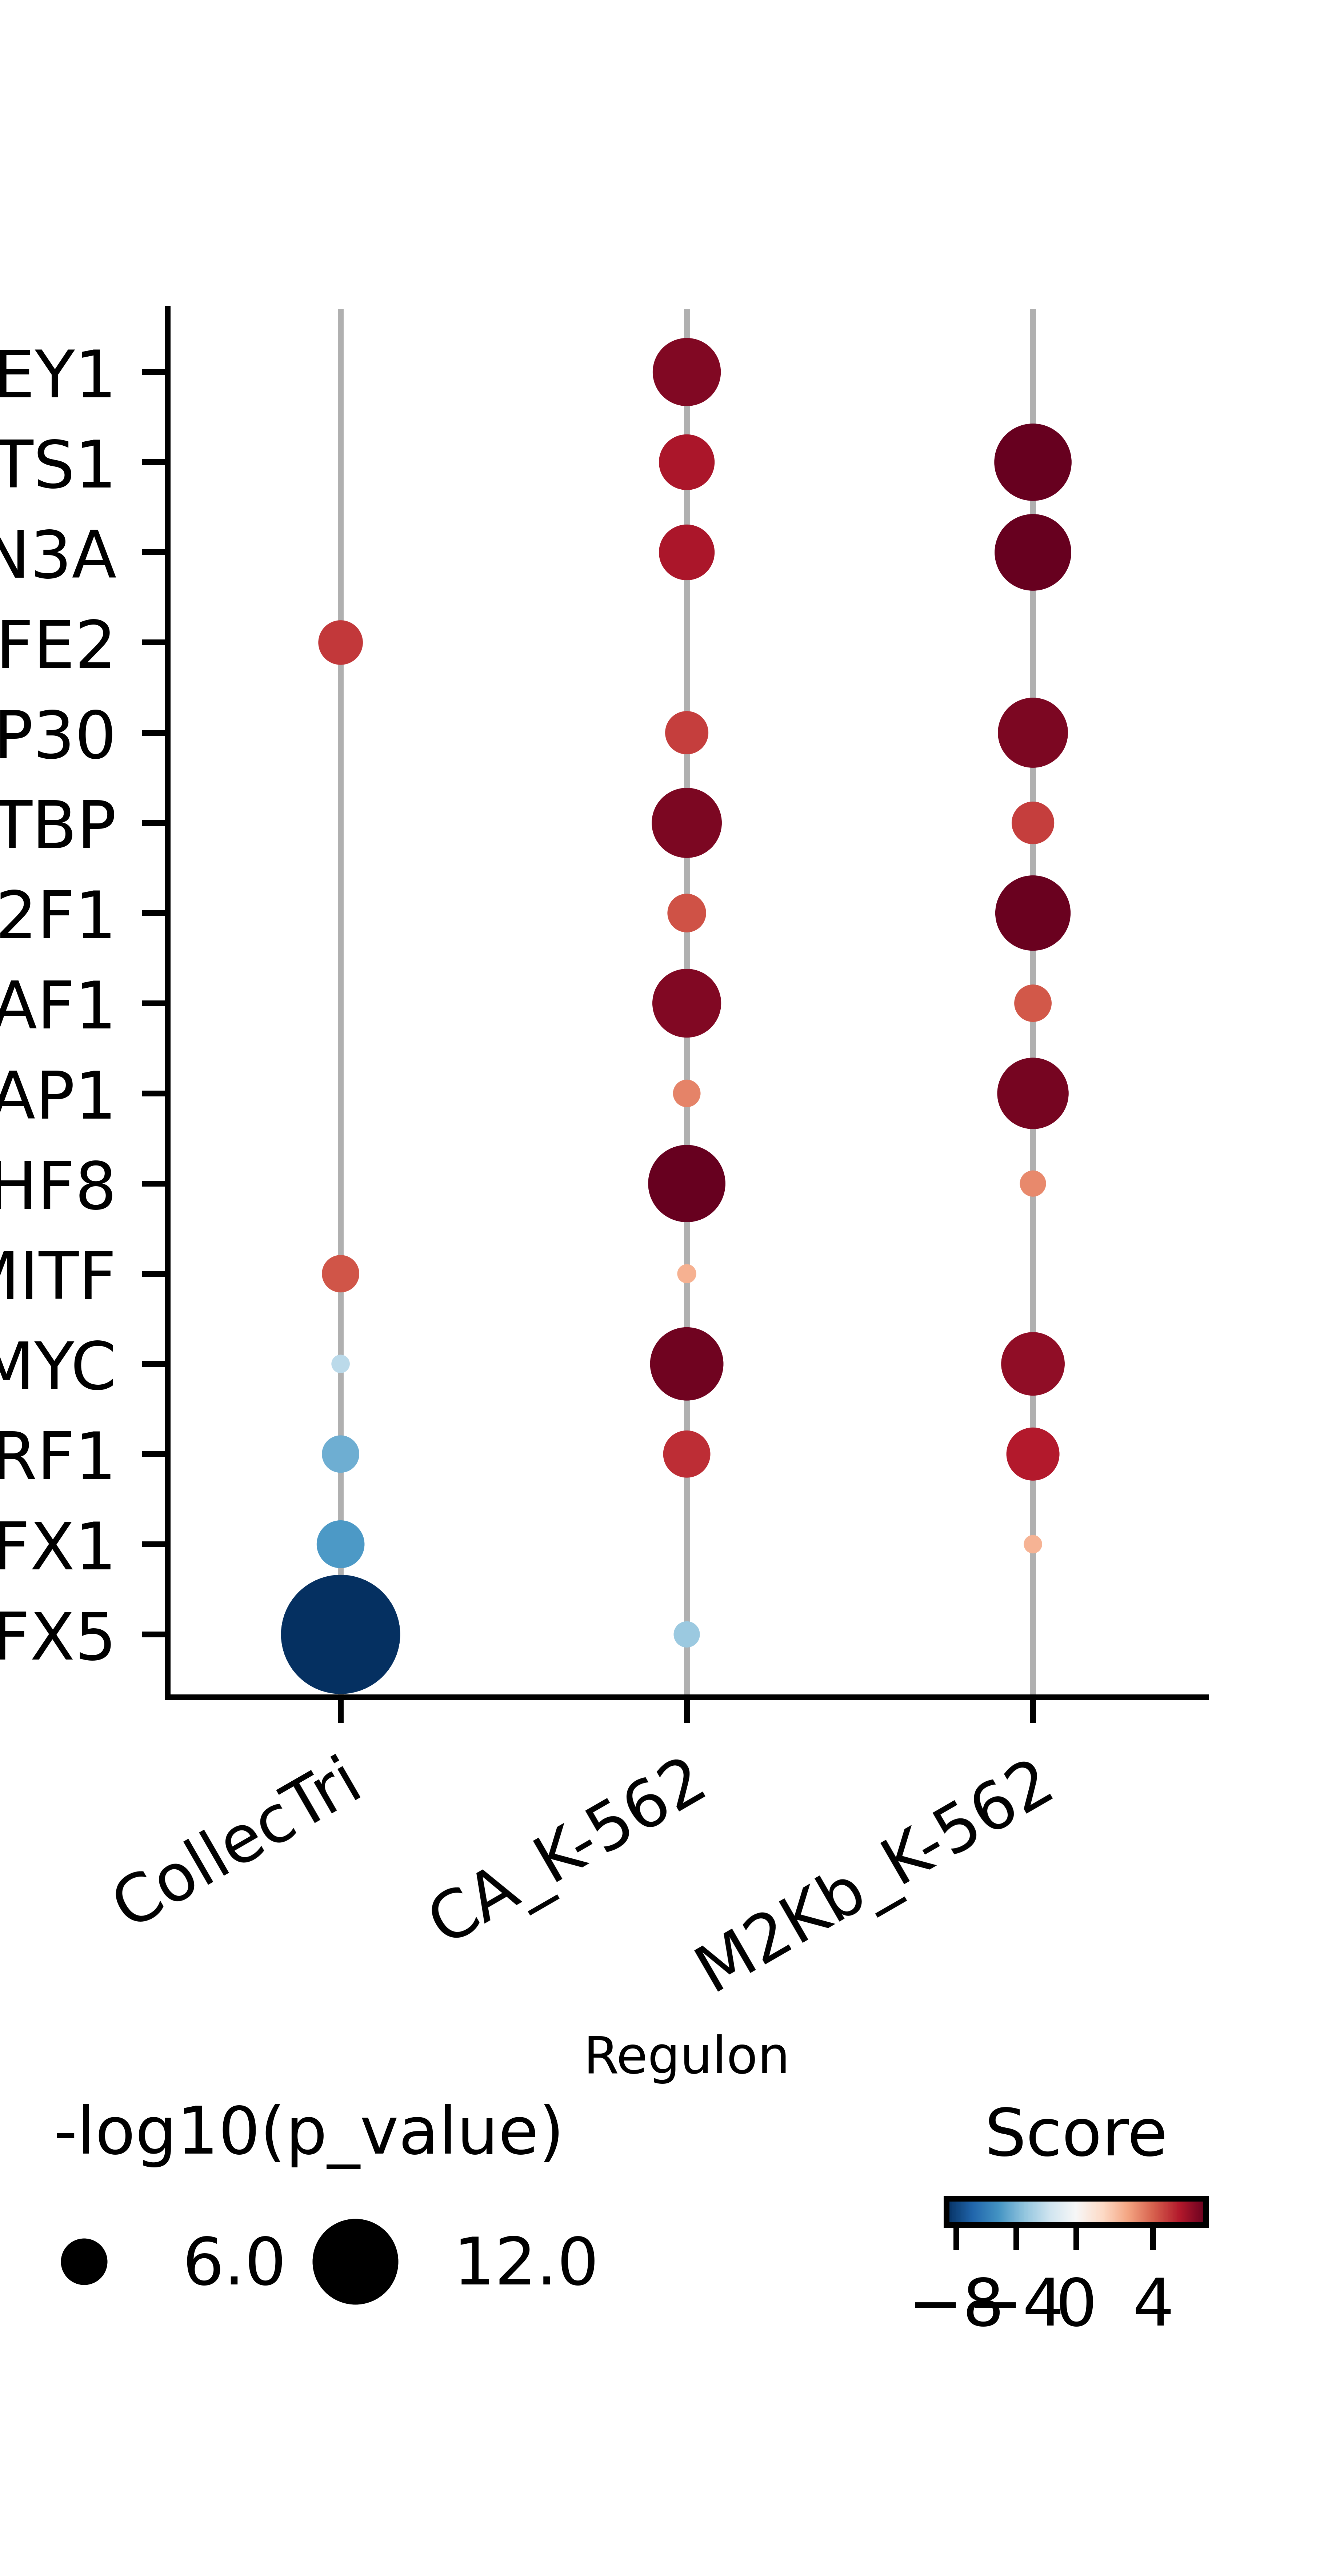

In [84]:
out = pd.DataFrame()
#interesting_tf = ["YY1", "MYB", "MYC", "SP1", "CREB1"]
interesting_tf = []
#for net in ["CollecTri", "M2Kb_K-562", "M2Kb_GM-12878", "CA_K-562", "CA_GM-12878"]:
for net in ["CollecTri", "M2Kb_K-562", "CA_K-562"]:
    mask = megaheat[megaheat.Network == net].score.abs().sort_values(ascending=False).head(5).index
    out = pd.concat([out, megaheat.loc[megaheat.TF.isin(mask) | megaheat.TF.isin(interesting_tf), :]])
plot_bubbles(out[out.Network.isin(["CollecTri", "M2Kb_K-562", "CA_K-562"])], scale=0.15)
plt.savefig("../plots/3-tf_activity/aml_activity_clustermap_dhsc_ahsc.svg", dpi=720, format="svg")
plt.show()

In [85]:
out

,score,p_value,Network,TF,log_p
RFX5,-8.666896,8.561306e-18,CollecTri,RFX5,17.1
RFX1,-5.004245,6.062165e-07,CollecTri,RFX1,6.2
IRF1,-4.248643,2.242190e-05,CollecTri,IRF1,4.6
RFX5,-3.216768,1.315643e-03,CA_K-562,RFX5,2.9
RFX1,2.333522,1.971225e-02,M2Kb_K-562,RFX1,1.7
MITF,2.403522,1.632196e-02,CA_K-562,MITF,1.8
MITF,4.227231,2.464550e-05,CollecTri,MITF,4.6
NFE2,4.751493,2.152257e-06,CollecTri,NFE2,5.7
IRF1,4.955431,7.778903e-07,CA_K-562,IRF1,6.1
IRF1,5.342521,1.013157e-07,M2Kb_K-562,IRF1,7.0


In [86]:
print(", ".join(megaheat[megaheat.Network == "M2Kb_GM-12878"].index.to_list()))

In [87]:
print(", ".join(megaheat[megaheat.Network == "M2Kb_K-562"].index.to_list()))

NFIX, MAFK, ZNF76, CBFA2T3, SP2, ZEB2, RUNX1, FOXK2, MTA2, ZBTB2, SMARCE1, ZBTB12, ZNF24, E2F1, GATA1, ESRRB, PHF20, MEIS2, BCOR, ZNF281, MIER1, ATF3, RFX1, SPI1, SIRT6, POU5F1, MYBL2, ATF1, KLF10, RLF, ELK1, PKNOX1, RREB1, KLF1, FOSL1, NR2F1, ID3, MGA, NR2C2, ZHX1, MEF2A, CEBPD, E2F7, ELF4, TCF7, IRF2, EP300, ATF7, ZMIZ1, ESRRA, CREB5, ZNF395, PLAG1, FOS, PRDM10, TBL1XR1, ZNF143, SMARCA4, KLF13, E4F1, USF1, PHF8, NR4A1, SKIL, HDGF, CREB3L1, SREBF1, NR2F2, ZNF263, ZNF148, CREM, PML, ZBED1, MTA3, HIF1A, REST, FUS, GATAD2B, GMEB1, ZFX, SRF, TFDP1, CTCF, E2F3, JUND, EGR1, TAF1, SMAD1, EWSR1, CTBP1, USF2, NEUROD1, MXI1, CREB1, SMAD5, JUN, VEZF1, TBP, SP1, SIN3B, GABPA, MAX, ELF1, BHLHE40, E2F6, KDM5B, ZBTB7A, MBD2, NFYB, RB1, IRF1, MNT, ERG, HDAC1, NONO, GFI1B, NRF1, E2F4, YY1, MAZ, CTCFL, HCFC1, MYC, NFYA, UBTF, BRD4, SAP30, THAP1, GTF2F1, SIN3A, ETS1


In [88]:
print(", ".join(megaheat[megaheat.Network == "CollecTri"].index.to_list()))

RFX5, RFX1, IRF1, CREB1, YY1, THRA, MEF2A, ATF3, RELA, NR2C2, YBX1, CEBPG, NFYB, MAFK, TBX21, MYC, SP1, HSF1, IKZF1, USF2, DLX4, EP300, ERG, ZEB1, BHLHE40, LEF1, MBD2, KLF1, MITF, NFE2


In [89]:
enr = gp.enrich(megaheat[megaheat.Network == "CollecTri"].index.to_list(), "KEGG_2021_Human")
enr.results.head(10)
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_kegg_enrich_collectri_dhsc_ahsc.tsv", sep="\t", index=False)

In [90]:
enr = gp.enrich(megaheat[megaheat.Network == "M2Kb_K-562"].index.to_list(), "KEGG_2021_Human")
enr.results.head(10)
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_kegg_enrich_m2kb_k562_dhsc_ahsc.tsv", sep="\t", index=False)